In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import bathy_tools
from salishsea_tools import nc_tools

In [33]:
factor_of_grid = 1.0 # amount of a grid point we deepen by
min_depth_deepen = 4.7 # minimum depth that we deepen

In [54]:
bathy = nc.Dataset('../../nemo-forcing/grid/bathy_meter_SalishSea6.nc', 'r')
print bathy.file_format
print bathy.variables.keys
depths = bathy.variables['Bathymetry'][:]

NETCDF4
<bound method OrderedDict.keys of OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7f4be8cb3348>), (u'nav_lat', <netCDF4.Variable object at 0x7f4be8cb3938>), (u'Bathymetry', <netCDF4.Variable object at 0x7f4be8cb3d60>)])>


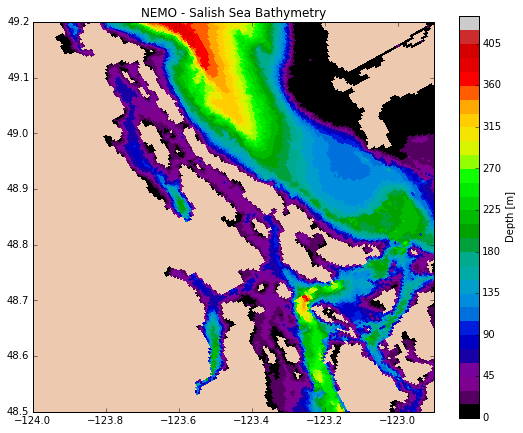

In [4]:
fig = bathy_tools.plot_colourmesh(
    bathy, 'NEMO - Salish Sea Bathymetry', 
    axis_limits=(-124, -122.9, 48.5, 49.2), colour_map='spectral', bins=30)

In [29]:
grid = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
#nc_tools.show_variable_attrs(grid)
depth_chunks = grid.variables['e3t_0'][0,:]
print depth_chunks, depth_chunks.shape
depth_places = grid.variables['gdept_0'][0,:]
print depth_places, depth_places.shape

 [  1.00000115   1.00000501   1.00001253   1.00002718   1.0000557
   1.00011125   1.00021946   1.0004302    1.00084067   1.00164012
   1.0031971    1.00622914   1.01213271   1.02362358   1.04597551
   1.08940061   1.17356428   1.33592899   1.64636781   2.22990285
   3.29248567   5.11998508   7.97451506  11.8252972   16.10792044
  19.95870258  22.81323256  24.64073198  25.70331479  26.28684983
  26.59728865  26.75965336  26.84381704  26.88724213  26.90959407
  26.92108493  26.9269885   26.93002054  26.93157752  26.93237697] (40,)
[   0.50000027    1.50000314    2.5000115     3.50003055    4.50007042
    5.50015083    6.50031022    7.50062342    8.50123623    9.50243254
   10.5047653    11.50931127   12.51816684   13.53541212   14.56898216
   15.63428737   16.76117342   18.00713456   19.48178514   21.38997868
   24.10025665   28.22991514   34.68575798   44.51772486   58.48433368
   76.58558445   98.06295924  121.8665184   147.08945807  173.11448217
  199.57304923  226.26030574  253.06663

In [67]:
new_depths = np.copy(depths)
mask = depths > 0
notmask = depths == 0

In [24]:
# stackoverflow by unutbu
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

In [68]:
imin = 0; imax = 898
jmin = 0; jmax = 398
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if depths[i,j] > min_depth_deepen:
            idx = find_nearest(depth_places, depths[i,j])
            new_depths[i,j] = depths[i,j] + factor_of_grid * depth_chunks[idx]

In [69]:
new_depths_masked = np.ma.array(new_depths, mask=notmask)

<matplotlib.colorbar.Colorbar instance at 0x7f4be6e89908>

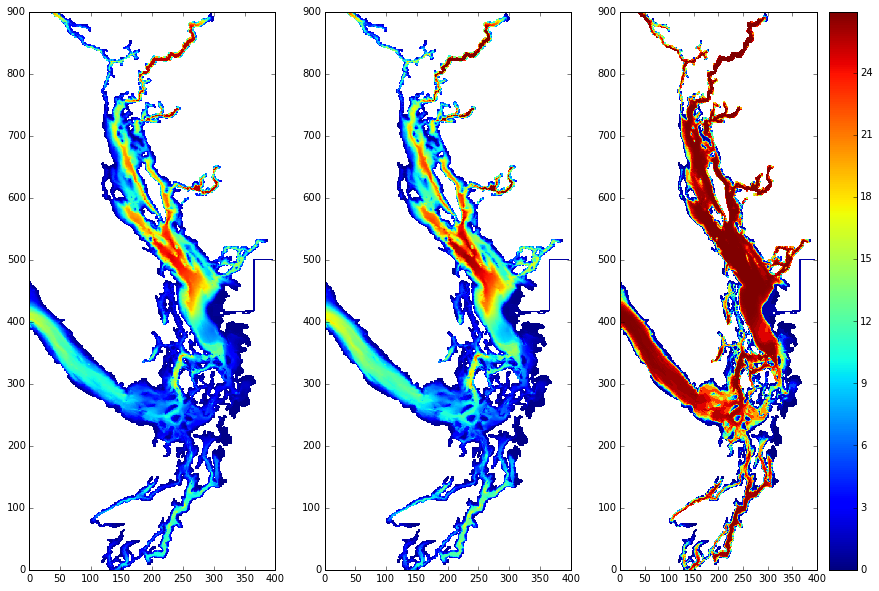

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].pcolormesh(depths[imin:imax, jmin:jmax], vmax=450, vmin=0)
axs[1].pcolormesh(new_depths_masked[imin:imax, jmin:jmax], vmax=450, vmin=0)
mesh = axs[2].pcolormesh(new_depths_masked - depths)
fig.colorbar(mesh, ax=axs[2])

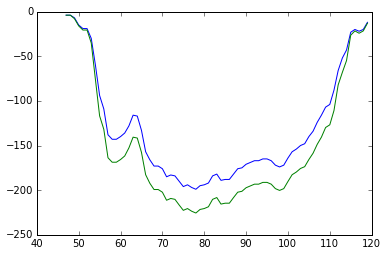

In [77]:
plt.plot(-depths[250:400,75])
plt.plot(-new_depths_masked[250:400,75])

In [78]:
# lets smooth
max_dh_over_hbar = 0.8
depthsmooth = bathy_tools.smooth(new_depths_masked[:], max_norm_depth_diff=max_dh_over_hbar, smooth_factor=0.2)

<matplotlib.colorbar.Colorbar instance at 0x7f4bdc59dcf8>

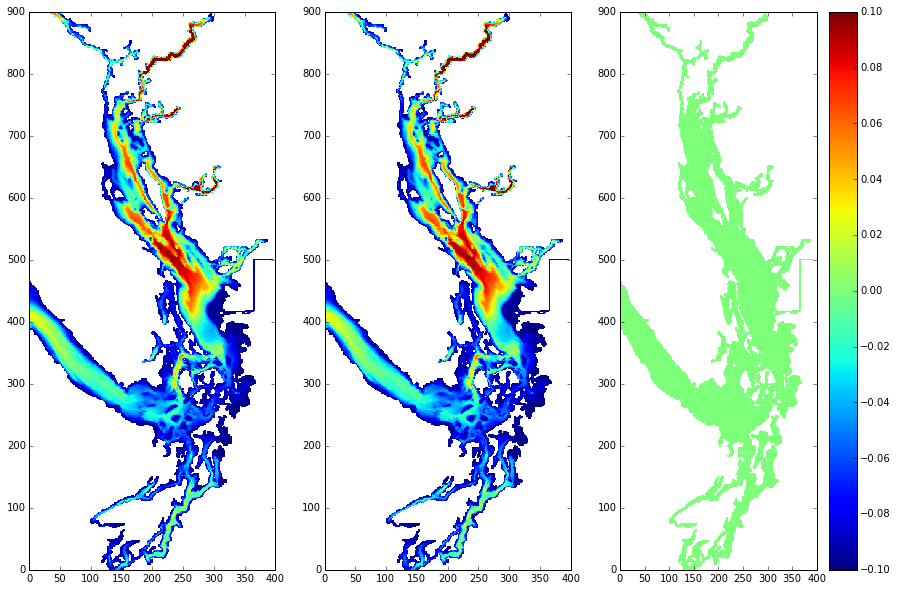

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].pcolormesh(new_depths_masked[imin:imax, jmin:jmax], vmax=450, vmin=0)
axs[1].pcolormesh(depthsmooth[imin:imax, jmin:jmax], vmax=450, vmin=0)
mesh = axs[2].pcolormesh(depthsmooth - new_depths_masked)
fig.colorbar(mesh, ax=axs[2])

<matplotlib.colorbar.Colorbar instance at 0x7f4bdc891488>

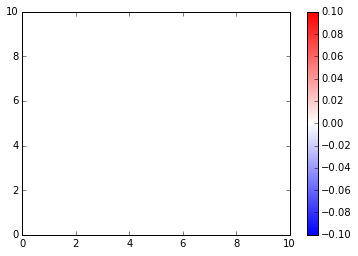

In [81]:
plt.pcolormesh(depthsmooth[imin-10:imax+10, jmin-10:jmax+10]-new_depths_masked[imin-10:imax+10, jmin-10:jmax+10], cmap = 'bwr')
plt.colorbar()

In [82]:
ysize = depthsmooth.shape[0]; xsize = depthsmooth.shape[1]
print ysize, xsize

new_bathy = nc.Dataset('bathy_downonegrid.nc', 'w')
new_bathy.createDimension('y', ysize)
new_bathy.createDimension('x', xsize)
nc_tools.show_dimensions(new_bathy)

898 398
<type 'netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4.Dimension'>: name = 'x', size = 398



In [83]:
newlons = new_bathy.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlats = new_bathy.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
newdepths = new_bathy.createVariable(
    'Bathymetry', float, ('y', 'x'), 
    zlib=True, least_significant_digit=0.1, fill_value=0)
newdepths.setncattr('units', 'metres')

newlons[:] = bathy.variables['nav_lon']
newlats[:] = bathy.variables['nav_lat']
newdepths[:] = depthsmooth[:]

In [84]:
nc_tools.show_dataset_attrs(new_bathy)

file format: NETCDF4


In [85]:
print bathy.history


    [2013-10-30 13:18] Created netCDF4 zlib=True dataset.
    [2013-10-30 15:22] Set depths between 0 and 4m to 4m and those >428m to 428m.
    [2013-10-31 17:10] Algorithmic smoothing.
    [2013-11-21 19:53] Reverted to pre-smothing dataset (repo rev 3b301b5b9b6d).
    [2013-11-21 20:14] Updated dataset and variable attributes to CF-1.6 conventions & project standards.
    [2013-11-21 20:47] Removed east end of Jervis Inlet and Toba Inlet region due to deficient source bathymetry data in Cascadia dataset.
    [2013-11-21 21:52] Algorithmic smoothing.



In [86]:
new_bathy.history = """
[2013-10-30 13:18] Created netCDF4 zlib=True dataset.
[2013-10-30 15:22] Set depths between 0 and 4m to 4m and those >428m to 428m.
[2013-10-31 17:10] Algorithmic smoothing.
[2013-11-21 19:53] Reverted to pre-smothing dataset (repo rev 3b301b5b9b6d).
[2013-11-21 20:14] Updated dataset and variable attributes to CF-1.6 conventions & project standards.
[2013-11-21 20:47] Removed east end of Jervis Inlet and Toba Inlet region due to deficient source bathymetry data in Cascadia dataset.
[2013-11-21 21:52] Algorithmic smoothing.
[2014-01-01 14:44] Smoothed mouth of Juan de Fuca
[2015-] Jie made Fraser River
[2015-12-24 11:46] dropped by one grid thickness, smoothed to 0.8
"""

In [87]:
new_bathy.conventions = """
CF-1.6"""

new_bathy.title= """
Salish Sea NEMO Bathymetry"""

new_bathy.institution= """ 
Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia"""

new_bathy.references= """ 
https://bitbucket.org/salishsea/nemo-forcing/src/tip/grid/bathy_downonegrid.nc"""

new_bathy.comment= """
Based on 1_bathymetry_seagrid_WestCoast.nc file from 2-Oct-2013 WCSD_PREP tarball provided by J-P Paquin.
"""

new_bathy.source= """ 
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/SalishSeaBathy.ipynb
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/SmoothMouthJdF.ipynb
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/Deepen by Grid Thickness.ipynb
"""

new_bathy.close()